<a href="https://colab.research.google.com/github/beifa/kaggle_ashrae/blob/master/final_))_v5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --user --upgrade catboost

Requirement already up-to-date: catboost in /root/.local/lib/python3.6/site-packages (0.20.2)


In [0]:
#after load neeed restart 
import catboost
from catboost import CatBoostRegressor, Pool, cv
print(catboost.__version__)

0.20.2


In [0]:
import gc
import os
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

path = '/content/drive/My Drive/ASHRAE/data/'

In [0]:
lgb.__version__

'2.2.3'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls '/content/drive/My Drive/ASHRAE/data/'

building_metadata.csv		droped_fetures_by_3.csv  test_lasttry.pkl.gz
data_test_before_fake.pkl	droped_fetures_by_4.csv  train.csv
data_test_ends.pkl.gz		droped_fetures_by_5.csv  train_full_fill.pkl.gz
data_test.pkl.gz		droped_fetures_by_6.csv  train_lasttry.pkl.gz
data_train_add_features.pkl.gz	metadata_fillNAN.pkl.gz  weather_test.csv
data_train_before_fake.pkl.gz	sample_submission.csv	 weather_train.csv
droped_fetures_by_2_1.csv	test2.hdf5
droped_fetures_by_2.csv		test_addTime.pkl.gz


#skip

In [0]:
train = pd.read_pickle(path + 'data_train_add_features.pkl.gz')
train.cloud_coverage = train.cloud_coverage.astype(np.int8)

In [0]:
test = pd.read_pickle(path + 'data_test_ends.pkl.gz')
test.cloud_coverage = test.cloud_coverage.astype(np.int8)

In [0]:
drop = ['es',
        'month', 
        'e',        
        'monthday',
        'precip_depth_1_hr', 
        'weekofyear',        
        'quarter',
        'mark_not_fill_wind_direction',
        'mark_not_fill_cloud_coverage',       
        'mark_not_fill_precip_depth_1_hr',
        'mark_not_fill_sea_level_pressure', 
        'mark_not_fill_wind_direction',         
        'rolling_back_air_temperature',        
        'rolling_back_h_air_temperature',
        'rolling_back_h_f_air_temperature',
        'rolling_back_dew_temperature',
        'rolling_forw_dew_temperature',
        'rolling_back_h_dew_temperature',
        'rolling_back_h_f_dew_temperature',
        'holiday',   
        'rec_dew'
        ]

In [0]:
def cook_data(data, droplist):
  """
  drop bad col,
  make cat  
  """
  cat = ['mark_not_fill_dew_temperature','mark_not_fill_air_temperature', 'mark_not_fill_wind_speed']
  cat2 = ['building_id','site_id', 'meter', 'primary_use', 'floor_count', 'cloud_coverage']  #'year_built' #need test very more val, more val  ha 117 ]
  #change
  data.rec_air = data.rec_air.cat.codes.astype("category")
  data.rec_dew = data.rec_dew.cat.codes.astype("category")
  data.rec_rh = data.rec_rh.cat.codes.astype("category")
  df = data.drop(droplist, axis = 'columns')  
  for col in cat + cat2:
    df[col] = df[col].astype('category')
  del data
  gc.collect()
  return df

In [0]:
train.shape, test.shape

((18338747, 45), (41697600, 44))

In [0]:
# df_train = cook_data(train, drop)
# df_test = cook_data(test, drop)

In [0]:
del train
del df_train
del test
del df_test

gc.collect()

#Save

In [0]:
# df_test.to_pickle(path + 'test_lasttry.pkl.gz')
# df_train.to_pickle(path + 'train_lasttry.pkl.gz')

#load

In [0]:
train = pd.read_pickle(path + 'train_lasttry.pkl.gz')
#test = pd.read_pickle(path + 'test_lasttry.pkl.gz')

#Test drop in table

In [0]:
drop_1 = ['air_temperature','rolling_forw_air_temperature', 'hour', 'site_id', 'rec_rh'] # 1.99
drop_2 = ['dayofyear', 'dew_temperature', 'primary_use', 'rec_air', 'floor_count', 'air_temperature', 'wind_direction'] #1.93
drop_3 = ['dew_temperature', 'rec_rh', 'rh', 'rolling_forw_air_temperature', 'air_temperature', 'wind_direction', 'hour']#1.95
drop_4 = ['rh', 'air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction', 'rec_air', 'dayofyear']#1.97

#bad site 1099 very big values drop???

In [0]:
def find_bad_building1099(df):
  #data = df
  #3351 row
  return df[(df.building_id == 1099) & (df.meter == 2) & (df.meter_reading > 3e4)].index

## experements

In [0]:
def experement(model, model_cat, data, b1099=False, logtarget= False, scaler = False, timestamp = True):
  """
  default model  need start score

  model = lgbm, cat,  ridge,/lasso  
  """
  scale = StandardScaler()  
  X = data.drop('meter_reading', axis = 1)
  y = data.meter_reading
  print(X.shape)
  
  if b1099:
    idx = find_bad_building1099(data)
    X = X.drop(idx)
    y = y.drop(idx)
  
  print(X.shape)  

  if logtarget:
    print('log target')
    y = np.log1p(y)
 
  x = X.copy() 
  if scaler: 
    print("Scale")           
    x = scale.fit_transform(x)   

  for reg in models:    
    reg.fit(x, y)    
    print(reg.__class__)
    score = [np.sqrt(mean_squared_log_error(y, np.clip(reg.predict(X), 0, None))) if logtarget else np.sqrt(mean_squared_error(y, reg.predict(X)))]
    print(score[0])
    print('++++++++++++')  
  
  del x

  idx_cat = np.where(data.drop(['meter_reading'], axis = 'columns').dtypes == 'category')[0]
  idx_for_scale = np.where(data.drop(['meter_reading'], axis = 'columns').dtypes != 'category')[0]  

  if scaler:  
    print('Scale lgbm.....')
    if timestamp:
      print('Draped timestamp ((: ')
      X_cat = X.iloc[:, idx_cat]
      times = X.iloc[:, idx_for_scale].timestamp
      X_cat = pd.concat([X_cat, times], axis = 'columns')      
      X_to_scale = scale.fit_transform(X.iloc[:, idx_for_scale[1:]])   
      X_scale = pd.DataFrame(X_to_scale, columns = X.iloc[:, idx_for_scale[1:]].columns, index = X.index)
      del times  
    else:
      print('Save scale timestamp :}} ')
      X_cat = X.iloc[:, idx_cat]
      X_to_scale = scale.fit_transform(X.iloc[:, idx_for_scale])    
      X_scale = pd.DataFrame(X_to_scale, columns = X.iloc[:, idx_for_scale].columns, index = X.index)   
    print(X_cat.shape, X_scale.shape)        
    X = pd.concat([X_cat, X_scale], axis = 'columns')
    idx_cat = np.where(X.dtypes == 'category')[0]  
    del X_cat    
    del X_scale
    gc.collect()

  train_pool = Pool(
      data=X, 
      label=y, 
      cat_features=idx_cat,      
      )
  model_cat.fit(train_pool)
  print('Cat')
  score = [np.sqrt(mean_squared_log_error(y, np.clip(model_cat.predict(X), 0, None))) if logtarget else np.sqrt(mean_squared_error(y, model_cat.predict(X)))]
  print(score[0])

In [0]:
model1 = Ridge(random_state=13)
model2 = Lasso(random_state=13)
model3 = LinearRegression()
model4 = LGBMRegressor(random_state=13)
#model_cat = catboost.CatBoostRegressor(random_state=13, iterations=10)
idx_cat = np.where(train.drop(['meter_reading'], axis = 'columns').dtypes == 'category')[0]
model_cat = catboost.CatBoostRegressor(random_state=13, iterations=10, cat_features=idx_cat)
models = [model1, model2, model3,  model4]

In [0]:
experement(models, model_cat, train, b1099=False, logtarget= False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.71101e-18): result may not be accurate.
  overwrite_a=True).T


<class 'sklearn.linear_model.ridge.Ridge'>
3.786931618470782
++++++++++++


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1680913262957267e+17, tolerance: 47468811498506.81
  positive)


<class 'sklearn.linear_model.coordinate_descent.Lasso'>
3.786592004809521
++++++++++++
<class 'sklearn.linear_model.base.LinearRegression'>
3.7869316483823123
++++++++++++
<class 'lightgbm.sklearn.LGBMRegressor'>
1.5232593520121835
++++++++++++
0:	learn: 1.7484424	total: 8.17s	remaining: 1m 13s
1:	learn: 1.7255085	total: 14.9s	remaining: 59.4s
2:	learn: 1.7036482	total: 20.7s	remaining: 48.3s
3:	learn: 1.6825374	total: 26.5s	remaining: 39.8s
4:	learn: 1.6624226	total: 32.4s	remaining: 32.4s
5:	learn: 1.6417114	total: 38.2s	remaining: 25.5s
6:	learn: 1.6233697	total: 43.8s	remaining: 18.8s
7:	learn: 1.6043289	total: 49.6s	remaining: 12.4s
8:	learn: 1.5865987	total: 55.8s	remaining: 6.2s
9:	learn: 1.5695606	total: 1m 1s	remaining: 0us
Cat
0.35068822237497216


In [0]:
experement(models, model_cat, train, b1099=True, logtarget= False)

(18338747, 24)
(18335396, 24)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.67782e-18): result may not be accurate.
  overwrite_a=True).T


<class 'sklearn.linear_model.ridge.Ridge'>
2.4978813080937936
++++++++++++


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161016807948030.72, tolerance: 36141603501.123535
  positive)


<class 'sklearn.linear_model.coordinate_descent.Lasso'>
2.4950934418466173
++++++++++++
<class 'sklearn.linear_model.base.LinearRegression'>
2.4978813556998443
++++++++++++
<class 'lightgbm.sklearn.LGBMRegressor'>
1.1686623591557126
++++++++++++
0:	learn: 1.7421539	total: 8.74s	remaining: 1m 18s
1:	learn: 1.7193771	total: 14.8s	remaining: 59.1s
2:	learn: 1.6976280	total: 20.8s	remaining: 48.5s
3:	learn: 1.6766732	total: 27.5s	remaining: 41.3s
4:	learn: 1.6556997	total: 33.3s	remaining: 33.3s
5:	learn: 1.6349993	total: 39.5s	remaining: 26.4s
6:	learn: 1.6152567	total: 45.4s	remaining: 19.4s
7:	learn: 1.5969763	total: 51.1s	remaining: 12.8s
8:	learn: 1.5801104	total: 56.9s	remaining: 6.32s
9:	learn: 1.5640803	total: 1m 2s	remaining: 0us
Cat
0.35015250357874433


In [0]:
experement(models, model_cat, train, b1099=True, logtarget= True)

(18338747, 24)
(18335396, 24)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.67782e-18): result may not be accurate.
  overwrite_a=True).T


<class 'sklearn.linear_model.ridge.Ridge'>
0.3277940135979935
++++++++++++
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
0.15235395758137768
++++++++++++
<class 'sklearn.linear_model.base.LinearRegression'>
0.08764896055091963
++++++++++++
<class 'lightgbm.sklearn.LGBMRegressor'>
0.0269436749345475
++++++++++++
0:	learn: 0.0633184	total: 7.82s	remaining: 1m 10s
1:	learn: 0.0627722	total: 13.4s	remaining: 53.6s
2:	learn: 0.0622539	total: 19.4s	remaining: 45.2s
3:	learn: 0.0617583	total: 24.7s	remaining: 37.1s
4:	learn: 0.0612845	total: 30.1s	remaining: 30.1s
5:	learn: 0.0608345	total: 35.3s	remaining: 23.5s
6:	learn: 0.0604072	total: 40.6s	remaining: 17.4s
7:	learn: 0.0599961	total: 46.7s	remaining: 11.7s
8:	learn: 0.0596054	total: 52.3s	remaining: 5.81s
9:	learn: 0.0592327	total: 57.5s	remaining: 0us
Cat
0.04330890282820915


In [0]:
experement(models, model_cat, train, b1099=False, logtarget= True)

(18338747, 24)
(18338747, 24)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.71101e-18): result may not be accurate.
  overwrite_a=True).T


<class 'sklearn.linear_model.ridge.Ridge'>
0.32788688770111013
++++++++++++
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
0.15237099727035744
++++++++++++
<class 'sklearn.linear_model.base.LinearRegression'>
0.08764820764994916
++++++++++++
<class 'lightgbm.sklearn.LGBMRegressor'>
0.027208684935232697
++++++++++++
0:	learn: 0.0633222	total: 7.98s	remaining: 1m 11s
1:	learn: 0.0627814	total: 14.2s	remaining: 56.8s
2:	learn: 0.0622610	total: 19.9s	remaining: 46.3s
3:	learn: 0.0617628	total: 25.8s	remaining: 38.7s
4:	learn: 0.0612882	total: 31s	remaining: 31s
5:	learn: 0.0608390	total: 36.3s	remaining: 24.2s
6:	learn: 0.0604054	total: 42s	remaining: 18s
7:	learn: 0.0599938	total: 47.2s	remaining: 11.8s
8:	learn: 0.0596024	total: 52.9s	remaining: 5.88s
9:	learn: 0.0592294	total: 58.6s	remaining: 0us
Cat
0.043300734992159653


default 1.09 kaggle, true, true

add scale

In [0]:
experement(models, model_cat, train, b1099=False, logtarget= True, scaler = True, timestamp = False)

(18338747, 24)
(18338747, 24)
log target
Scale
<class 'sklearn.linear_model.ridge.Ridge'>
9.155661089576492
++++++++++++
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
0.38303437714773436
++++++++++++
<class 'sklearn.linear_model.base.LinearRegression'>
1.7004447887192375
++++++++++++
<class 'lightgbm.sklearn.LGBMRegressor'>
0.42091667836173524
++++++++++++
Scale lgbm.....
Save scale timestamp :}} 
(18338747, 11) (18338747, 13)
0:	learn: 1.7484424	total: 2.65s	remaining: 23.8s
1:	learn: 1.7255085	total: 4.16s	remaining: 16.6s
2:	learn: 1.7036482	total: 5.44s	remaining: 12.7s
3:	learn: 1.6825374	total: 6.48s	remaining: 9.72s
4:	learn: 1.6624226	total: 7.87s	remaining: 7.87s
5:	learn: 1.6417114	total: 8.94s	remaining: 5.96s
6:	learn: 1.6233697	total: 10s	remaining: 4.29s
7:	learn: 1.6043289	total: 11.3s	remaining: 2.83s
8:	learn: 1.5865987	total: 12.6s	remaining: 1.39s
9:	learn: 1.5695606	total: 14s	remaining: 0us
Cat
0.35068822237497216


In [0]:
experement(models, model_cat, train, b1099=True, logtarget= False, scaler = True, timestamp = False)

(18338747, 24)
(18335396, 24)
Scale
<class 'sklearn.linear_model.ridge.Ridge'>
[87758470.356816]
++++++++++++
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
[87507080.86138201]
++++++++++++
<class 'sklearn.linear_model.base.LinearRegression'>
[9.971850287047176e+18]
++++++++++++
<class 'lightgbm.sklearn.LGBMRegressor'>
[23500.630888958298]
++++++++++++
Scale lgbm.....
Save scale timestamp :}} 
(18335396, 11) (18335396, 13)
0:	learn: 4423.7189774	total: 1.76s	remaining: 15.9s
1:	learn: 4408.6028081	total: 3.28s	remaining: 13.1s
2:	learn: 4394.3002897	total: 4.33s	remaining: 10.1s
3:	learn: 4380.8139079	total: 5.38s	remaining: 8.07s
4:	learn: 4368.0703436	total: 6.63s	remaining: 6.63s
5:	learn: 4356.0219133	total: 7.66s	remaining: 5.11s
6:	learn: 4344.6652428	total: 8.85s	remaining: 3.79s
7:	learn: 4333.8777850	total: 10s	remaining: 2.5s
8:	learn: 4323.6647653	total: 11.2s	remaining: 1.25s
9:	learn: 4314.0320884	total: 12.3s	remaining: 0us
Cat
[4314.024230996538]


In [0]:
experement(models, model_cat, train, b1099=True, logtarget= True, scaler = False, timestamp = False)

(18338747, 24)
(18335396, 24)
log target


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.67782e-18): result may not be accurate.
  overwrite_a=True).T


<class 'sklearn.linear_model.ridge.Ridge'>
0.3277940135979935
++++++++++++
<class 'sklearn.linear_model.coordinate_descent.Lasso'>
0.33763165895602415
++++++++++++
<class 'sklearn.linear_model.base.LinearRegression'>
0.32779401358105187
++++++++++++
<class 'lightgbm.sklearn.LGBMRegressor'>
0.14141168519030134
++++++++++++
0:	learn: 1.7421539	total: 1.8s	remaining: 16.2s
1:	learn: 1.7193771	total: 3.15s	remaining: 12.6s
2:	learn: 1.6976280	total: 4.46s	remaining: 10.4s
3:	learn: 1.6766732	total: 5.84s	remaining: 8.76s
4:	learn: 1.6556997	total: 7.24s	remaining: 7.24s
5:	learn: 1.6349993	total: 8.64s	remaining: 5.76s
6:	learn: 1.6152567	total: 9.77s	remaining: 4.19s
7:	learn: 1.5969763	total: 11.3s	remaining: 2.84s
8:	learn: 1.5801104	total: 12.4s	remaining: 1.38s
9:	learn: 1.5640803	total: 13.5s	remaining: 0us
Cat
0.35015250357874433


1.064558 kaggle with scale but strange, true, true, true, false








#loop drops features

In [0]:
drop_1 = ['air_temperature','rolling_forw_air_temperature', 'hour', 'site_id', 'rec_rh'] # 1.99
drop_2 = ['dayofyear', 'dew_temperature', 'primary_use', 'rec_air', 'floor_count', 'air_temperature', 'wind_direction'] #1.93
drop_3 = ['dew_temperature', 'rec_rh', 'rh', 'rolling_forw_air_temperature', 'air_temperature', 'wind_direction', 'hour']#1.95
drop_4 = ['rh', 'air_temperature', 'dew_temperature', 'wind_speed', 'wind_direction', 'rec_air', 'dayofyear']#1.97

In [0]:
def frac_data(data, frac):
    return data if frac == 1 else np.random.choice(data, int(len(data) * frac), replace=False)

def idx_split(df, frac):
  idx = np.argsort(df.timestamp.values, kind='stable')
  split = np.array_split(idx, 12)
  box = []
  for x in range(0, 12, 2):
    test_idx = np.concatenate(split[x:x + 2])
    train_idx = np.concatenate([split[ix % 12] for ix in range(x + 3, x + 11)])
    box.append((frac_data(train_idx, frac), frac_data(test_idx, frac)))
  return box

def cv_model(model, split, X, y, verbose = True):
  box = []
  by_splits = pd.DataFrame()
  for n, (train_idx, test_idx) in enumerate(split):
    train = X.iloc[train_idx]
    target = y.reindex_like(train)
    test = X.iloc[test_idx]
    target_test = y.reindex_like(test)
    print(f'Fit model {n}')    
    model.fit(train, target)          
    box.append(pd.DataFrame(dict(target=target_test,
                                 prediction=model.predict(test)),
                                 index=target_test.index))    
    by_splits.loc[n, 'train'] = np.sqrt(mean_squared_log_error(np.expm1(target), np.clip(np.expm1(model.predict(train)), 0, None)))
    by_splits.loc[n, 'test'] = np.sqrt(mean_squared_log_error(np.expm1(target_test), np.clip(np.expm1(model.predict(test)), 0, None)))     
      
  result = pd.concat(box).sort_index()  #check???  
  y = np.expm1(result.target)
  pred = np.expm1(result.prediction)
  if verbose:
    print(f'RMSE: {np.sqrt(mean_squared_log_error(y, np.clip(pred, 0, None)))}')
    print('--------------------')
  print(model.__class__)
  by_splits['std'] = by_splits.std(axis = 1, ddof = 1)
  display(by_splits)
  print(f'Std train: {by_splits.std()[0]}, Std test: {by_splits.std()[1]}')

In [0]:
def experement(model, model_cat, data, frac = 0.25, b1099=False, logtarget= False, scaler = False, timestamp = True):
  #same change for cv
  scale = StandardScaler()  
  X = data.drop('meter_reading', axis = 1)
  y = data.meter_reading
  print(X.shape)
  
  if b1099:
    idx = find_bad_building1099(data)
    X = X.drop(idx)
    y = y.drop(idx)
  
  print(X.shape) 
  splits = idx_split(X, frac) 

  if logtarget:
    print('log target')
    y = np.log1p(y)
 
  x = X.copy() 
  if scaler: 
    print("Scale")           
    x = pd.DataFrame(scale.fit_transform(x), columns = X.columns, index= X.index)

  for reg in models:
    cv_model(reg, splits, x, y, verbose = True)    
  del x

  idx_cat = np.where(data.drop(['meter_reading'], axis = 'columns').dtypes == 'category')[0]
  idx_for_scale = np.where(data.drop(['meter_reading'], axis = 'columns').dtypes != 'category')[0]  

  if scaler:  
    print('Scale cat....')
    if timestamp:
      print('Draped timestamp ((: ')
      X_cat = X.iloc[:, idx_cat]
      times = X.iloc[:, idx_for_scale].timestamp
      X_cat = pd.concat([X_cat, times], axis = 'columns')      
      X_to_scale = scale.fit_transform(X.iloc[:, idx_for_scale[1:]])   
      X_scale = pd.DataFrame(X_to_scale, columns = X.iloc[:, idx_for_scale[1:]].columns, index = X.index)
      del times  
    else:
      print('Save scale timestamp :}} ')
      X_cat = X.iloc[:, idx_cat]
      X_to_scale = scale.fit_transform(X.iloc[:, idx_for_scale])    
      X_scale = pd.DataFrame(X_to_scale, columns = X.iloc[:, idx_for_scale].columns, index = X.index)   
    print(X_cat.shape, X_scale.shape)        
    X = pd.concat([X_cat, X_scale], axis = 'columns')
    idx_cat = np.where(X.dtypes == 'category')[0]  
    del X_cat    
    del X_scale
    gc.collect()

  train_pool = Pool(
      data=X, 
      label=y, 
      cat_features=idx_cat,
      ) 
  
  params = {"iterations": 10, 
            'depth': 2}
  scores = cv(train_pool,
              params,
              folds = splits)
  display(scores)

In [0]:
experement(models, model_cat, train, frac = 0.25, b1099=True, logtarget= True, scaler = True, timestamp = True)

(18338747, 24)
(18335396, 24)
log target
Scale lgbm.....
Save scale timestamp :}} 
(18335396, 11) (18335396, 13)
0:	learn: 4.7628900	test: 4.7639475	best: 4.7639475 (0)	total: 15s	remaining: 2m 14s
1:	learn: 4.6337321	test: 4.6350758	best: 4.6350758 (1)	total: 21.9s	remaining: 1m 27s
2:	learn: 4.5087719	test: 4.5109610	best: 4.5109610 (2)	total: 29.2s	remaining: 1m 8s
3:	learn: 4.3878806	test: 4.3909231	best: 4.3909231 (3)	total: 36.4s	remaining: 54.6s
4:	learn: 4.2710304	test: 4.2748353	best: 4.2748353 (4)	total: 43.3s	remaining: 43.3s
5:	learn: 4.1580247	test: 4.1626897	best: 4.1626897 (5)	total: 50.3s	remaining: 33.5s
6:	learn: 4.0486956	test: 4.0534172	best: 4.0534172 (6)	total: 57.1s	remaining: 24.5s
7:	learn: 3.9431087	test: 3.9486959	best: 3.9486959 (7)	total: 1m 3s	remaining: 16s
8:	learn: 3.8408514	test: 3.8465484	best: 3.8465484 (8)	total: 1m 10s	remaining: 7.86s
9:	learn: 3.7420691	test: 3.7483621	best: 3.7483621 (9)	total: 1m 17s	remaining: 0us
   iterations  test-RMSE-mean

In [0]:
experement(models, model_cat, train, frac = 0.25, b1099=True, logtarget= True, scaler = True, timestamp = True)

(18338747, 24)
(18335396, 24)
log target
Scale lgbm.....
Draped timestamp ((: 
(18335396, 12) (18335396, 12)
0:	learn: 4.7637708	test: 4.7644918	best: 4.7644918 (0)	total: 11.9s	remaining: 1m 46s
1:	learn: 4.6345355	test: 4.6357332	best: 4.6357332 (1)	total: 17.2s	remaining: 1m 8s
2:	learn: 4.5095648	test: 4.5116171	best: 4.5116171 (2)	total: 22.7s	remaining: 53.1s
3:	learn: 4.3886675	test: 4.3915772	best: 4.3915772 (3)	total: 28.3s	remaining: 42.4s
4:	learn: 4.2718114	test: 4.2755766	best: 4.2755766 (4)	total: 33.5s	remaining: 33.5s
5:	learn: 4.1588107	test: 4.1634391	best: 4.1634391 (5)	total: 38.9s	remaining: 25.9s
6:	learn: 4.0494548	test: 4.0541495	best: 4.0541495 (6)	total: 44.2s	remaining: 19s
7:	learn: 3.9438747	test: 3.9494307	best: 3.9494307 (7)	total: 49.5s	remaining: 12.4s
8:	learn: 3.8416097	test: 3.8472761	best: 3.8472761 (8)	total: 54.9s	remaining: 6.1s
9:	learn: 3.7429717	test: 3.7494682	best: 3.7494682 (9)	total: 1m	remaining: 0us
   iterations  test-RMSE-mean  test-RM

In [0]:
experement(models, model_cat, train, frac = 0.25, b1099=True, logtarget= True, scaler = True, timestamp = True)

(18338747, 24)
(18335396, 24)
log target
Scale
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4702083799335344
--------------------
<class 'sklearn.linear_model.ridge.Ridge'>


,train,test,std
0,1.445719,1.496729,0.036069
1,1.469047,1.419103,0.035316
2,1.454038,1.465345,0.007995
3,1.443724,1.494474,0.035886
4,1.454213,1.457987,0.002668
5,1.442626,1.486140,0.030768


Std train: 0.009942896570840912, Std test: 0.02942901833848134
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.7668267704493763
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.745791,1.809517,0.045061
1,1.772516,1.752556,0.014114
2,1.776903,1.740911,0.025450
3,1.773454,1.754571,0.013352
4,1.774483,1.748288,0.018523
5,1.752060,1.794004,0.029659


Std train: 0.013352860497973325, Std test: 0.0280357433896492
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4702066861067125
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.445719,1.496729,0.036070
1,1.469048,1.419110,0.035311
2,1.454038,1.465343,0.007994
3,1.443726,1.494446,0.035865
4,1.454214,1.458000,0.002677
5,1.442626,1.486140,0.030768


Std train: 0.009943035671234952, Std test: 0.029420988701856988
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.9050079335739023
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.835485,0.927356,0.064962
1,0.854486,0.861450,0.004925
2,0.841791,0.894126,0.037006
3,0.832435,0.928838,0.068168
4,0.851234,0.874723,0.016610
5,0.834643,0.940643,0.074953


Std train: 0.009258963180290248, Std test: 0.03246103962051747
Scale lgbm.....
Draped timestamp ((: 
(18335396, 12) (18335396, 12)
0:	learn: 4.7632967	test: 4.7627189	best: 4.7627189 (0)	total: 12.1s	remaining: 1m 49s
1:	learn: 4.6340662	test: 4.6339784	best: 4.6339784 (1)	total: 17.2s	remaining: 1m 8s
2:	learn: 4.5091040	test: 4.5098815	best: 4.5098815 (2)	total: 23s	remaining: 53.7s
3:	learn: 4.3882140	test: 4.3898668	best: 4.3898668 (3)	total: 28.3s	remaining: 42.4s
4:	learn: 4.2713657	test: 4.2738887	best: 4.2738887 (4)	total: 33.4s	remaining: 33.4s
5:	learn: 4.1583725	test: 4.1617699	best: 4.1617699 (5)	total: 38.4s	remaining: 25.6s
6:	learn: 4.0490162	test: 4.0524894	best: 4.0524894 (6)	total: 43.5s	remaining: 18.6s
7:	learn: 3.9434687	test: 3.9477443	best: 3.9477443 (7)	total: 48.6s	remaining: 12.1s
8:	learn: 3.8411926	test: 3.8455945	best: 3.8455945 (8)	total: 53.7s	remaining: 5.97s
9:	learn: 3.7423312	test: 3.7472697	best: 3.7472697 (9)	total: 58.8s	remaining: 0us
   iteration

In [0]:
experement(models, model_cat, train, frac = 0.25, b1099=True, logtarget= True, scaler = True, timestamp = True)

(18338747, 24)
(18335396, 24)
log target
Scale
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.470581275870095
--------------------
<class 'sklearn.linear_model.ridge.Ridge'>


,train,test,std
0,1.445328,1.494736,0.034937
1,1.468069,1.419730,0.034181
2,1.453498,1.465087,0.008195
3,1.443032,1.495638,0.037198
4,1.456075,1.459692,0.002557
5,1.441990,1.487169,0.031947


Std train: 0.009995451898504197, Std test: 0.029054278116385553
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.7672496941216105
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.745258,1.807714,0.044163
1,1.771155,1.753904,0.012198
2,1.777998,1.740818,0.026290
3,1.773178,1.756043,0.012117
4,1.775697,1.750293,0.017963
5,1.751926,1.793700,0.029538


Std train: 0.013742601086327601, Std test: 0.026931938081835808
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4705594787269485
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.445329,1.494649,0.034875
1,1.468070,1.419753,0.034166
2,1.453498,1.465088,0.008195
3,1.443026,1.495735,0.037271
4,1.456074,1.459704,0.002566
5,1.441990,1.486995,0.031824


Std train: 0.009996523725615564, Std test: 0.02902772525583692
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.9081645533104693
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.844269,0.945372,0.071491
1,0.854635,0.865838,0.007922
2,0.844451,0.896777,0.037001
3,0.831183,0.932611,0.071720
4,0.842156,0.866175,0.016984
5,0.833315,0.938585,0.074437


Std train: 0.008515761930706722, Std test: 0.03630332637550413
Scale lgbm.....
Draped timestamp ((: 
(18335396, 12) (18335396, 12)
0:	learn: 4.7630427	test: 4.7645862	best: 4.7645862 (0)	total: 11.9s	remaining: 1m 46s
1:	learn: 4.6338483	test: 4.6358581	best: 4.6358581 (1)	total: 17s	remaining: 1m 8s
2:	learn: 4.5088893	test: 4.5117463	best: 4.5117463 (2)	total: 23.4s	remaining: 54.6s
3:	learn: 4.3880022	test: 4.3917125	best: 4.3917125 (3)	total: 28.8s	remaining: 43.2s
4:	learn: 4.2711559	test: 4.2757173	best: 4.2757173 (4)	total: 34s	remaining: 34s
5:	learn: 4.1581656	test: 4.1635892	best: 4.1635892 (5)	total: 39.2s	remaining: 26.1s
6:	learn: 4.0488149	test: 4.0542985	best: 4.0542985 (6)	total: 44.3s	remaining: 19s
7:	learn: 3.9432721	test: 3.9495547	best: 3.9495547 (7)	total: 49.6s	remaining: 12.4s
8:	learn: 3.8409094	test: 3.8472997	best: 3.8472997 (8)	total: 54.7s	remaining: 6.07s
9:	learn: 3.7421963	test: 3.7493174	best: 3.7493174 (9)	total: 59.9s	remaining: 0us
   iterations  tes

In [0]:
experement(models, model_cat, train, frac = 0.25, b1099=True, logtarget= True, scaler = False, timestamp = False)

(18338747, 24)
(18335396, 24)
log target
Fit model 0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.24986e-17): result may not be accurate.
  overwrite_a=True).T


Fit model 1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.22928e-17): result may not be accurate.
  overwrite_a=True).T


Fit model 2


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.18835e-17): result may not be accurate.
  overwrite_a=True).T


Fit model 3


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.20278e-17): result may not be accurate.
  overwrite_a=True).T


Fit model 4


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21585e-17): result may not be accurate.
  overwrite_a=True).T


Fit model 5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.21409e-17): result may not be accurate.
  overwrite_a=True).T


RMSE: 1.4688618341790656
--------------------
<class 'sklearn.linear_model.ridge.Ridge'>


,train,test,std
0,1.445828,1.494769,0.034607
1,1.469318,1.419124,0.035493
2,1.453477,1.464344,0.007684
3,1.444232,1.492396,0.034057
4,1.454489,1.457233,0.001940
5,1.443173,1.483916,0.028810


Std train: 0.009841591163771611, Std test: 0.02856855965608407
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.520849546725
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.501273,1.540898,0.028019
1,1.530743,1.483615,0.033325
2,1.525770,1.499999,0.018223
3,1.517771,1.520166,0.001694
4,1.519644,1.511629,0.005667
5,1.497799,1.567321,0.049160


Std train: 0.013235426162296646, Std test: 0.029892764089236565
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.468861841683469
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.445828,1.494769,0.034607
1,1.469318,1.419124,0.035493
2,1.453477,1.464344,0.007684
3,1.444232,1.492396,0.034057
4,1.454489,1.457233,0.001940
5,1.443173,1.483916,0.028810


Std train: 0.009841591164197997, Std test: 0.028568556001679863
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.6775237120064065
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.519381,0.752462,0.164813
1,0.533819,0.623110,0.063138
2,0.540980,0.623710,0.058498
3,0.536774,0.679174,0.100692
4,0.530667,0.617953,0.061721
5,0.506524,0.753398,0.174567


Std train: 0.012821665922291042, Std test: 0.06440743770637558
0:	learn: 4.7634080	test: 4.7617754	best: 4.7617754 (0)	total: 11.6s	remaining: 1m 44s
1:	learn: 4.6341835	test: 4.6330632	best: 4.6330632 (1)	total: 16.7s	remaining: 1m 6s
2:	learn: 4.5092213	test: 4.5089676	best: 4.5089676 (2)	total: 22.2s	remaining: 51.8s
3:	learn: 4.3883326	test: 4.3889553	best: 4.3889553 (3)	total: 27.5s	remaining: 41.3s
4:	learn: 4.2714851	test: 4.2729748	best: 4.2729748 (4)	total: 32.4s	remaining: 32.4s
5:	learn: 4.1584924	test: 4.1608607	best: 4.1608607 (5)	total: 37.6s	remaining: 25.1s
6:	learn: 4.0491354	test: 4.0515933	best: 4.0515933 (6)	total: 42.7s	remaining: 18.3s
7:	learn: 3.9435894	test: 3.9468591	best: 3.9468591 (7)	total: 48.2s	remaining: 12s
8:	learn: 3.8413095	test: 3.8446913	best: 3.8446913 (8)	total: 53.5s	remaining: 5.94s
9:	learn: 3.7425092	test: 3.7465718	best: 3.7465718 (9)	total: 58.8s	remaining: 0us
   iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
0 

In [0]:
experement(models, model_cat, train, frac = 0.25, b1099=True, logtarget= True, scaler = True, timestamp = False)

(18338747, 24)
(18335396, 24)
log target
Scale
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4706122232519074
--------------------
<class 'sklearn.linear_model.ridge.Ridge'>


,train,test,std
0,1.446217,1.497397,0.036190
1,1.469150,1.419920,0.034811
2,1.452855,1.465492,0.008935
3,1.444414,1.492959,0.034327
4,1.455013,1.461594,0.004654
5,1.442461,1.484917,0.030021


Std train: 0.009851911156160615, Std test: 0.028630013003074977
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.767375180911998
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.745981,1.809865,0.045173
1,1.772411,1.752984,0.013737
2,1.776105,1.740825,0.024947
3,1.773408,1.754695,0.013232
4,1.774280,1.751672,0.015987
5,1.751978,1.793138,0.029105


Std train: 0.013141229633672738, Std test: 0.027525775375545725
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4706212800299687
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.446217,1.497398,0.036190
1,1.469148,1.419911,0.034816
2,1.452855,1.465492,0.008935
3,1.444417,1.493068,0.034401
4,1.455014,1.461593,0.004651
5,1.442461,1.484872,0.029989


Std train: 0.009851261556558171, Std test: 0.028646081514337243
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.9037620461954627
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.835898,0.932860,0.068563
1,0.854752,0.863730,0.006348
2,0.840668,0.890448,0.035200
3,0.834099,0.928799,0.066963
4,0.844647,0.867104,0.015879
5,0.833821,0.936495,0.072601


Std train: 0.008086685507676519, Std test: 0.03366610759946683
Scale lgbm.....
Save scale timestamp :}} 
(18335396, 11) (18335396, 13)
0:	learn: 4.7627551	test: 4.7640090	best: 4.7640090 (0)	total: 12.1s	remaining: 1m 48s
1:	learn: 4.6335885	test: 4.6351328	best: 4.6351328 (1)	total: 17.5s	remaining: 1m 9s
2:	learn: 4.5086362	test: 4.5110182	best: 4.5110182 (2)	total: 23.4s	remaining: 54.5s
3:	learn: 4.3877492	test: 4.3909759	best: 4.3909759 (3)	total: 29.1s	remaining: 43.6s
4:	learn: 4.2709098	test: 4.2749749	best: 4.2749749 (4)	total: 34.3s	remaining: 34.3s
5:	learn: 4.1579169	test: 4.1628340	best: 4.1628340 (5)	total: 39.7s	remaining: 26.5s
6:	learn: 4.0486025	test: 4.0535765	best: 4.0535765 (6)	total: 45.1s	remaining: 19.3s
7:	learn: 3.9430312	test: 3.9488589	best: 3.9488589 (7)	total: 50.7s	remaining: 12.7s
8:	learn: 3.8407804	test: 3.8467130	best: 3.8467130 (8)	total: 56.1s	remaining: 6.24s
9:	learn: 3.7420578	test: 3.7487449	best: 3.7487449 (9)	total: 1m 1s	remaining: 0us
   ite

#1 true, tru, False, False

In [0]:
for n, drop in enumerate([drop_1, drop_2, drop_3, drop_4]):
  print(f'Model: {n}')
  data = train.drop(drop, axis = 1)
  experement(models, model_cat, data, frac = 0.5, b1099=True, logtarget= True, scaler = False, timestamp = False)  
  print('Ends')
  print('====================')
  del data
  gc.collect()
  

Model: 0
(18338747, 19)
(18335396, 19)
log target
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4893005410884248
--------------------
<class 'sklearn.linear_model.ridge.Ridge'>


,train,test,std
0,1.465369,1.500498,0.024840
1,1.486466,1.433727,0.037293
2,1.469412,1.480287,0.007690
3,1.455562,1.532607,0.054479
4,1.468537,1.482012,0.009528
5,1.460699,1.504837,0.031211


Std train: 0.010560013082371072, Std test: 0.033059065457635206
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.5219994070858236
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.500940,1.542892,0.029664
1,1.530646,1.482359,0.034144
2,1.525273,1.499428,0.018276
3,1.517303,1.522346,0.003566
4,1.519521,1.514123,0.003817
5,1.497171,1.569267,0.050979


Std train: 0.013352833125261268, Std test: 0.03102679281989528
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4893005433671007
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.465369,1.500498,0.024840
1,1.486466,1.433727,0.037293
2,1.469412,1.480287,0.007690
3,1.455562,1.532607,0.054479
4,1.468537,1.482012,0.009528
5,1.460699,1.504837,0.031211


Std train: 0.010560013082086043, Std test: 0.03305906376005526
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.7354067670020609
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.570957,0.763389,0.136070
1,0.567584,0.685870,0.083641
2,0.578837,0.691647,0.079769
3,0.584579,0.711870,0.090009
4,0.588743,0.688971,0.070872
5,0.562072,0.855537,0.207511


Std train: 0.010320411328569524, Std test: 0.06671583737452148
0:	learn: 4.7633265	test: 4.7634813	best: 4.7634813 (0)	total: 27s	remaining: 4m 2s
1:	learn: 4.6342076	test: 4.6350086	best: 4.6350086 (1)	total: 38.9s	remaining: 2m 35s
2:	learn: 4.5093070	test: 4.5107451	best: 4.5107451 (2)	total: 50.5s	remaining: 1m 57s
3:	learn: 4.3884460	test: 4.3906319	best: 4.3906319 (3)	total: 1m 2s	remaining: 1m 33s
4:	learn: 4.2715758	test: 4.2746263	best: 4.2746263 (4)	total: 1m 13s	remaining: 1m 13s
5:	learn: 4.1585403	test: 4.1623223	best: 4.1623223 (5)	total: 1m 25s	remaining: 56.9s
6:	learn: 4.0490883	test: 4.0529174	best: 4.0529174 (6)	total: 1m 36s	remaining: 41.5s
7:	learn: 3.9434225	test: 3.9481258	best: 3.9481258 (7)	total: 1m 48s	remaining: 27.1s
8:	learn: 3.8412959	test: 3.8462787	best: 3.8462787 (8)	total: 2m	remaining: 13.4s
9:	learn: 3.7424664	test: 3.7481123	best: 3.7481123 (9)	total: 2m 12s	remaining: 0us
   iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-s

,train,test,std
0,1.459465,1.483027,0.016661
1,1.481975,1.431133,0.035950
2,1.468198,1.472429,0.002992
3,1.457862,1.498531,0.028758
4,1.467126,1.472876,0.004066
5,1.455720,1.506655,0.036017


Std train: 0.009701307022715946, Std test: 0.02653234937958878
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.5222440423420622
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.500689,1.540933,0.028457
1,1.530282,1.484192,0.032591
2,1.525897,1.500997,0.017607
3,1.518139,1.522145,0.002833
4,1.519894,1.514138,0.004070
5,1.498137,1.569564,0.050506


Std train: 0.01321939077993882, Std test: 0.030176755352172218
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4776406046198622
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.459465,1.483027,0.016661
1,1.481975,1.431133,0.035950
2,1.468198,1.472429,0.002992
3,1.457862,1.498531,0.028758
4,1.467126,1.472876,0.004066
5,1.455720,1.506655,0.036017


Std train: 0.009701307023431372, Std test: 0.026532348690472378
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.8394966417144633
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.541915,0.900130,0.253296
1,0.546486,0.763845,0.153696
2,0.537340,0.827119,0.204905
3,0.543957,0.788433,0.172871
4,0.547120,0.669094,0.086249
5,0.520578,1.039901,0.367217


Std train: 0.009952191671739306, Std test: 0.1272540243691624
0:	learn: 4.7636766	test: 4.7636417	best: 4.7636417 (0)	total: 25.6s	remaining: 3m 50s
1:	learn: 4.6344755	test: 4.6349197	best: 4.6349197 (1)	total: 37.3s	remaining: 2m 29s
2:	learn: 4.5095738	test: 4.5105276	best: 4.5105276 (2)	total: 48.8s	remaining: 1m 53s
3:	learn: 4.3888067	test: 4.3902801	best: 4.3902801 (3)	total: 1m	remaining: 1m 30s
4:	learn: 4.2718821	test: 4.2742246	best: 4.2742246 (4)	total: 1m 12s	remaining: 1m 12s
5:	learn: 4.1587789	test: 4.1619919	best: 4.1619919 (5)	total: 1m 24s	remaining: 56.2s
6:	learn: 4.0494799	test: 4.0532298	best: 4.0532298 (6)	total: 1m 36s	remaining: 41.2s
7:	learn: 3.9436892	test: 3.9476728	best: 3.9476728 (7)	total: 1m 48s	remaining: 27s
8:	learn: 3.8413214	test: 3.8455098	best: 3.8455098 (8)	total: 1m 59s	remaining: 13.3s
9:	learn: 3.7424393	test: 3.7468049	best: 3.7468049 (9)	total: 2m 11s	remaining: 0us
   iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-

,train,test,std
0,1.449639,1.484819,0.024876
1,1.472357,1.421742,0.035790
2,1.458025,1.464569,0.004628
3,1.445879,1.506243,0.042684
4,1.458009,1.464479,0.004575
5,1.446182,1.489588,0.030692


Std train: 0.010090894642876245, Std test: 0.029270614567501893
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.5224526538692025
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.501146,1.541469,0.028512
1,1.530248,1.484414,0.032410
2,1.525739,1.499070,0.018857
3,1.517019,1.522689,0.004009
4,1.519533,1.515569,0.002803
5,1.497615,1.569975,0.051167


Std train: 0.013163156109390544, Std test: 0.03053116946228715
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.47214923246368
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.449639,1.484819,0.024876
1,1.472357,1.421742,0.035790
2,1.458025,1.464569,0.004628
3,1.445879,1.506243,0.042684
4,1.458009,1.464479,0.004575
5,1.446182,1.489588,0.030692


Std train: 0.01009089464272032, Std test: 0.029270614624103426
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.7904828613885535
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.575174,0.832400,0.181886
1,0.570953,0.723475,0.107850
2,0.567334,0.716881,0.105746
3,0.574956,0.767901,0.136433
4,0.569409,0.700127,0.092431
5,0.556207,0.969074,0.291940


Std train: 0.006985680248700298, Std test: 0.10203057118505195
0:	learn: 4.7635676	test: 4.7636718	best: 4.7636718 (0)	total: 25.7s	remaining: 3m 51s
1:	learn: 4.6343753	test: 4.6350599	best: 4.6350599 (1)	total: 37.6s	remaining: 2m 30s
2:	learn: 4.5094991	test: 4.5108098	best: 4.5108098 (2)	total: 49.1s	remaining: 1m 54s
3:	learn: 4.3886019	test: 4.3905972	best: 4.3905972 (3)	total: 1m	remaining: 1m 31s
4:	learn: 4.2717148	test: 4.2743228	best: 4.2743228 (4)	total: 1m 12s	remaining: 1m 12s
5:	learn: 4.1587090	test: 4.1617563	best: 4.1617563 (5)	total: 1m 23s	remaining: 55.8s
6:	learn: 4.0493065	test: 4.0530537	best: 4.0530537 (6)	total: 1m 35s	remaining: 40.9s
7:	learn: 3.9436958	test: 3.9483211	best: 3.9483211 (7)	total: 1m 47s	remaining: 26.9s
8:	learn: 3.8414998	test: 3.8463826	best: 3.8463826 (8)	total: 1m 59s	remaining: 13.3s
9:	learn: 3.7424908	test: 3.7474631	best: 3.7474631 (9)	total: 2m 11s	remaining: 0us
   iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RM

,train,test,std
0,1.453146,1.473743,0.014564
1,1.474344,1.420249,0.038251
2,1.457768,1.466635,0.006270
3,1.445954,1.496548,0.035775
4,1.457666,1.464319,0.004704
5,1.446955,1.499982,0.037496


Std train: 0.010327414954232377, Std test: 0.02876155950881258
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.5227954858763695
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.501221,1.543148,0.029647
1,1.530079,1.483514,0.032926
2,1.525397,1.499963,0.017985
3,1.516967,1.522905,0.004199
4,1.519133,1.514678,0.003151
5,1.496975,1.570968,0.052321


Std train: 0.013199625721340532, Std test: 0.03119188348720057
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.470480224773486
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.453146,1.473743,0.014564
1,1.474344,1.420249,0.038251
2,1.457768,1.466635,0.006270
3,1.445954,1.496548,0.035775
4,1.457666,1.464319,0.004704
5,1.446955,1.499982,0.037496


Std train: 0.010327414954145046, Std test: 0.028761559464270083
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.8158207362217091
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.538435,0.895428,0.252432
1,0.551616,0.709446,0.111602
2,0.538139,0.749885,0.149727
3,0.543846,0.778537,0.165951
4,0.547473,0.679530,0.093378
5,0.522296,1.028625,0.358029


Std train: 0.010240779491696581, Std test: 0.13173823969236562
0:	learn: 4.7632877	test: 4.7641563	best: 4.7641563 (0)	total: 26.3s	remaining: 3m 57s
1:	learn: 4.6340980	test: 4.6355369	best: 4.6355369 (1)	total: 38.6s	remaining: 2m 34s
2:	learn: 4.5092240	test: 4.5112829	best: 4.5112829 (2)	total: 50.6s	remaining: 1m 58s
3:	learn: 4.3883429	test: 4.3910854	best: 4.3910854 (3)	total: 1m 2s	remaining: 1m 34s
4:	learn: 4.2714575	test: 4.2748121	best: 4.2748121 (4)	total: 1m 14s	remaining: 1m 14s
5:	learn: 4.1584922	test: 4.1623810	best: 4.1623810 (5)	total: 1m 26s	remaining: 57.7s
6:	learn: 4.0491079	test: 4.0537728	best: 4.0537728 (6)	total: 1m 38s	remaining: 42.2s
7:	learn: 3.9434942	test: 3.9487727	best: 3.9487727 (7)	total: 1m 51s	remaining: 27.8s
8:	learn: 3.8413048	test: 3.8470015	best: 3.8470015 (8)	total: 2m 4s	remaining: 13.8s
9:	learn: 3.7422122	test: 3.7479884	best: 3.7479884 (9)	total: 2m 16s	remaining: 0us
   iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-

#2 all true

In [0]:
for n, drop in enumerate([drop_1, drop_2, drop_3, drop_4]):
  print(f'Model: {n}')
  data = train.drop(drop, axis = 1)
  experement(models, model_cat, data, frac = 0.5, b1099=True, logtarget= True, scaler = True, timestamp = True)  
  print('Ends')
  print('====================')
  del data
  gc.collect()

Model: 0
(18338747, 19)
(18335396, 19)
log target
Scale
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4900177783467832
--------------------
<class 'sklearn.linear_model.ridge.Ridge'>


,train,test,std
0,1.464394,1.498095,0.023830
1,1.486663,1.436278,0.035628
2,1.469606,1.481438,0.008367
3,1.455760,1.533484,0.054959
4,1.469550,1.483154,0.009620
5,1.460714,1.505907,0.031956


Std train: 0.010666809191110979, Std test: 0.03229638567086582
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.7672897680286852
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.744903,1.806918,0.043851
1,1.772128,1.753459,0.013201
2,1.777500,1.740629,0.026072
3,1.773165,1.756260,0.011954
4,1.775129,1.752428,0.016052
5,1.752208,1.793062,0.028888


Std train: 0.013708543028214792, Std test: 0.026378291049856988
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4899982172480588
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.464390,1.498226,0.023926
1,1.486660,1.436259,0.035639
2,1.469603,1.481417,0.008354
3,1.455758,1.533354,0.054869
4,1.469547,1.483124,0.009600
5,1.460711,1.505861,0.031926


Std train: 0.010666752096991857, Std test: 0.03227190444382297
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.9280997509519728
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.846097,0.954493,0.076647
1,0.858904,0.874758,0.011210
2,0.847633,0.913379,0.046489
3,0.843138,0.948404,0.074434
4,0.856724,0.889605,0.023251
5,0.846378,0.983275,0.096800


Std train: 0.0064080642132807375, Std test: 0.04169734932003091
Scale lgbm.....
Draped timestamp ((: 
(18335396, 10) (18335396, 9)
0:	learn: 4.7634442	test: 4.7639384	best: 4.7639384 (0)	total: 27.7s	remaining: 4m 9s
1:	learn: 4.6343260	test: 4.6354806	best: 4.6354806 (1)	total: 40.2s	remaining: 2m 40s
2:	learn: 4.5094253	test: 4.5112301	best: 4.5112301 (2)	total: 52.7s	remaining: 2m 2s
3:	learn: 4.3885633	test: 4.3911272	best: 4.3911272 (3)	total: 1m 4s	remaining: 1m 37s
4:	learn: 4.2716925	test: 4.2751299	best: 4.2751299 (4)	total: 1m 17s	remaining: 1m 17s
5:	learn: 4.1586560	test: 4.1628339	best: 4.1628339 (5)	total: 1m 29s	remaining: 59.6s
6:	learn: 4.0491472	test: 4.0533641	best: 4.0533641 (6)	total: 1m 41s	remaining: 43.6s
7:	learn: 3.9434335	test: 3.9484027	best: 3.9484027 (7)	total: 1m 54s	remaining: 28.5s
8:	learn: 3.8412937	test: 3.8465531	best: 3.8465531 (8)	total: 2m 6s	remaining: 14.1s
9:	learn: 3.7424404	test: 3.7483768	best: 3.7483768 (9)	total: 2m 19s	remaining: 0us
   

,train,test,std
0,1.460206,1.482752,0.015942
1,1.481756,1.431022,0.035874
2,1.467640,1.471323,0.002604
3,1.457531,1.498221,0.028773
4,1.466330,1.473988,0.005415
5,1.454718,1.506783,0.036815


Std train: 0.009730667851925806, Std test: 0.026551796045550156
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.7671316241635437
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.745302,1.808534,0.044712
1,1.771530,1.752995,0.013106
2,1.777406,1.740273,0.026256
3,1.773639,1.754023,0.013870
4,1.774579,1.752127,0.015876
5,1.751871,1.793779,0.029633


Std train: 0.01356606115965853, Std test: 0.027357770681124535
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4775470518652432
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.460206,1.482752,0.015942
1,1.481756,1.431022,0.035874
2,1.467640,1.471323,0.002604
3,1.457531,1.498221,0.028773
4,1.466330,1.473988,0.005415
5,1.454718,1.506783,0.036815


Std train: 0.009730667851943403, Std test: 0.02655179382763772
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.0262431324988406
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.869875,1.055833,0.131493
1,0.885508,0.920990,0.025090
2,0.876756,1.025750,0.105355
3,0.872181,1.026680,0.109247
4,0.880721,0.955809,0.053095
5,0.866413,1.155957,0.204738


Std train: 0.007124954204669283, Std test: 0.08209249128516466
Scale lgbm.....
Draped timestamp ((: 
(18335396, 9) (18335396, 8)
0:	learn: 4.7631416	test: 4.7637869	best: 4.7637869 (0)	total: 26.1s	remaining: 3m 54s
1:	learn: 4.6339703	test: 4.6350964	best: 4.6350964 (1)	total: 38.4s	remaining: 2m 33s
2:	learn: 4.5090834	test: 4.5107166	best: 4.5107166 (2)	total: 50.4s	remaining: 1m 57s
3:	learn: 4.3883268	test: 4.3904750	best: 4.3904750 (3)	total: 1m 2s	remaining: 1m 34s
4:	learn: 4.2714152	test: 4.2744346	best: 4.2744346 (4)	total: 1m 14s	remaining: 1m 14s
5:	learn: 4.1583229	test: 4.1622144	best: 4.1622144 (5)	total: 1m 27s	remaining: 58.2s
6:	learn: 4.0490420	test: 4.0531940	best: 4.0531940 (6)	total: 1m 39s	remaining: 42.7s
7:	learn: 3.9432107	test: 3.9474499	best: 3.9474499 (7)	total: 1m 51s	remaining: 28s
8:	learn: 3.8410856	test: 3.8458684	best: 3.8458684 (8)	total: 2m 4s	remaining: 13.8s
9:	learn: 3.7422049	test: 3.7471595	best: 3.7471595 (9)	total: 2m 16s	remaining: 0us
   it

,train,test,std
0,1.449155,1.484714,0.025144
1,1.473084,1.421193,0.036692
2,1.457760,1.464717,0.004919
3,1.446370,1.505710,0.041959
4,1.457951,1.463297,0.003780
5,1.445415,1.489679,0.031299


Std train: 0.010429134556907648, Std test: 0.02939189348244144
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.7667319903184027
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.745390,1.808323,0.044500
1,1.772476,1.752120,0.014393
2,1.777152,1.739724,0.026466
3,1.773578,1.754775,0.013295
4,1.774503,1.750909,0.016684
5,1.751866,1.793471,0.029419


Std train: 0.013567475574839066, Std test: 0.027498517303051584
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.471774651770905
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.449152,1.484825,0.025225
1,1.473081,1.421197,0.036687
2,1.457758,1.464694,0.004905
3,1.446368,1.505567,0.041860
4,1.457949,1.463249,0.003747
5,1.445412,1.489651,0.031281


Std train: 0.01042914203505244, Std test: 0.029368037687963405
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 0.9813063358343186
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.855964,1.014406,0.112036
1,0.868099,0.908479,0.028553
2,0.859098,0.968916,0.077653
3,0.847249,0.989282,0.100433
4,0.860986,0.909829,0.034537
5,0.849023,1.085427,0.167162


Std train: 0.007782518341029462, Std test: 0.06714851658036478
Scale lgbm.....
Draped timestamp ((: 
(18335396, 11) (18335396, 6)
0:	learn: 4.7633510	test: 4.7638022	best: 4.7638022 (0)	total: 26.6s	remaining: 3m 59s
1:	learn: 4.6341641	test: 4.6351716	best: 4.6351716 (1)	total: 39.2s	remaining: 2m 36s
2:	learn: 4.5092922	test: 4.5109018	best: 4.5109018 (2)	total: 51.2s	remaining: 1m 59s
3:	learn: 4.3884140	test: 4.3906919	best: 4.3906919 (3)	total: 1m 3s	remaining: 1m 34s
4:	learn: 4.2715321	test: 4.2744087	best: 4.2744087 (4)	total: 1m 15s	remaining: 1m 15s
5:	learn: 4.1585693	test: 4.1619654	best: 4.1619654 (5)	total: 1m 27s	remaining: 58.2s
6:	learn: 4.0491735	test: 4.0533455	best: 4.0533455 (6)	total: 1m 39s	remaining: 42.5s
7:	learn: 3.9435787	test: 3.9485233	best: 3.9485233 (7)	total: 1m 51s	remaining: 28s
8:	learn: 3.8413976	test: 3.8465936	best: 3.8465936 (8)	total: 2m 3s	remaining: 13.8s
9:	learn: 3.7423061	test: 3.7475738	best: 3.7475738 (9)	total: 2m 16s	remaining: 0us
   i

,train,test,std
0,1.452903,1.472021,0.013518
1,1.474517,1.420412,0.038258
2,1.457935,1.466962,0.006383
3,1.446644,1.495733,0.034711
4,1.458241,1.464406,0.004359
5,1.447900,1.498737,0.035947


Std train: 0.010134954026579709, Std test: 0.028252915231591322
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.7669147580434357
--------------------
<class 'sklearn.linear_model.coordinate_descent.Lasso'>


,train,test,std
0,1.745545,1.807678,0.043935
1,1.772140,1.751895,0.014316
2,1.777193,1.741051,0.025556
3,1.773776,1.754843,0.013387
4,1.774545,1.750875,0.016737
5,1.752520,1.794099,0.029401


Std train: 0.013390767718588967, Std test: 0.027195462883080654
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.4699380784601812
--------------------
<class 'sklearn.linear_model.base.LinearRegression'>


,train,test,std
0,1.452903,1.472021,0.013518
1,1.474517,1.420412,0.038258
2,1.457935,1.466962,0.006383
3,1.446644,1.495733,0.034711
4,1.458241,1.464406,0.004359
5,1.447900,1.498737,0.035947


Std train: 0.010134954026550857, Std test: 0.02825290096285966
Fit model 0
Fit model 1
Fit model 2
Fit model 3
Fit model 4
Fit model 5
RMSE: 1.0277707882971052
--------------------
<class 'lightgbm.sklearn.LGBMRegressor'>


,train,test,std
0,0.842953,1.040297,0.139543
1,0.859835,0.920497,0.042894
2,0.854254,1.019552,0.116884
3,0.843295,1.002749,0.112751
4,0.857607,1.043472,0.131426
5,0.841111,1.128946,0.203530


Std train: 0.008320723692008111, Std test: 0.06755824903337412
Scale lgbm.....
Draped timestamp ((: 
(18335396, 11) (18335396, 6)
0:	learn: 4.7636503	test: 4.7637605	best: 4.7637605 (0)	total: 26.7s	remaining: 4m
1:	learn: 4.6344533	test: 4.6351356	best: 4.6351356 (1)	total: 38.9s	remaining: 2m 35s
2:	learn: 4.5095724	test: 4.5108729	best: 4.5108729 (2)	total: 50.8s	remaining: 1m 58s
3:	learn: 4.3886858	test: 4.3906696	best: 4.3906696 (3)	total: 1m 3s	remaining: 1m 34s
4:	learn: 4.2717966	test: 4.2743893	best: 4.2743893 (4)	total: 1m 15s	remaining: 1m 15s
5:	learn: 4.1588102	test: 4.1618371	best: 4.1618371 (5)	total: 1m 27s	remaining: 58.4s
6:	learn: 4.0494153	test: 4.0532144	best: 4.0532144 (6)	total: 1m 39s	remaining: 42.9s
7:	learn: 3.9437491	test: 3.9481509	best: 3.9481509 (7)	total: 1m 52s	remaining: 28.2s
8:	learn: 3.8416136	test: 3.8465310	best: 3.8465310 (8)	total: 2m 4s	remaining: 13.9s
9:	learn: 3.7426335	test: 3.7477438	best: 3.7477438 (9)	total: 2m 16s	remaining: 0us
   ite

#Best True, true, false, false, and first drop

#boxcox1p??

#iwant

In [0]:
win_drops = ['air_temperature','rolling_forw_air_temperature', 'hour', 'rec_rh'] # 1.99 site_id not dropen need for clusters
train = train.drop(win_drops, axis = 1)
idx_bad = find_bad_building1099(train)
train = train.drop(idx_bad)

In [0]:
test = test.drop(win_drops, axis = 1)

In [0]:
test.shape, train.shape

((41697600, 20), (18335396, 21))

In [0]:
def cost(target, pred):
  return np.sqrt(mean_squared_log_error(np.expm1(target), np.clip(np.expm1(pred), 0, None)))

def cluster_id(data, test, mark, model, num_cluster, skip = True):  
  """
  че мы хотим, а мы хотим
  разбиваем на  сайт ид и в нем делаем кластеры
  затем учим и предсказывае для каждого кластера в сайт ид

  data = data
  num_clusters = int, num cluster  
  mark = feature test
  """
  data.building_id = data.building_id.astype(np.int16)
  test.building_id = test.building_id.astype(np.int16)  
  df_id = pd.DataFrame(data = np.zeros(len(test)), columns = ['pred'], index=test.index)  
  for id_ in data.site_id.unique():      
    mask_id = data.site_id == id_
    mask_id_test = test.site_id == id_       
    site_id = data[mask_id] 
    site_id_test = test[mask_id_test]         
    #we make cluster in site id    
    if skip:        
      g = site_id.groupby(mark)['meter_reading'].median()      
      km = KMeans(n_clusters=num_cluster, init='random', n_init=5, max_iter=100, random_state=13, n_jobs=-1)      
      label = km.fit_predict(g.values.reshape(-1, 1))      
      g = g.to_frame()        
      g['labels'] = label
      cluster_df = site_id[mark].map(g['labels']) #i make idx - labels
      cluster_test = site_id_test[mark].map(g['labels'])      
      for num in range(num_cluster):
        #num clusters
        idx = cluster_df[cluster_df == num].index #index cluster in id_site
        #idx_box[id_] = idx #index clusters only site_id
        #site_id.loc[cluster_df[cluster_df == 1].index]        
        X = site_id.loc[idx].drop('meter_reading', axis = 1)
        y = site_id.loc[idx]['meter_reading']      
        # learning
        # predict for cluster
        # join for predict site
        # add for predict sample train         
        model.fit(X, np.log1p(y))
        #model.fit(X.drop('site_id', axis = 1), np.log1p(y))
        idx_test = cluster_test[cluster_test == num].index 
        test_cluster = site_id_test.loc[idx_test]                
        df_id.loc[idx_test, 'pred'] = model.predict(test_cluster)
     
    else:   
      pass   
      X = site_id.drop('meter_reading', axis = 1)
      y = site_id['meter_reading']
      model.fit(X, y)            
      df_id.loc[site_id.index, 'pred'] = model.predict(test)
  #print(cost(np.log1p(data.meter_reading.values), df_id.pred.values)  )
  return df_id

In [0]:
lr = LinearRegression()
pred = cluster_id(train, test, 'building_id', lr, 3, skip = True)

In [0]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 1 columns):
pred    float64
dtypes: float64(1)
memory usage: 1.9 GB


In [0]:
#del pred
gc.collect()

1205

#w

In [0]:
X = train.drop('meter_reading', axis = 1)
y = train.meter_reading
del train
gc.collect()

0

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
#all method data df, and need convert
train = pd.concat([X_train, y_train], axis = 1)

In [0]:
model1 = Lasso(alpha = 1, random_state=13)
pred_model1 = cluster_id(train, X_test, 'building_id', model1, 3, skip = True)
cost(np.log1p(y_test), pred_model1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


1.2454373330905504

##lgbm



In [0]:
params = {'bagging_fraction': 0.1,
          'boosting_type': 'gbdt',
          'feature_fraction': 0.7,
          'learning_rate': 0.1,
          'max_bin': 63,
          'max_depth': -1,
          'min_data_in_leaf': 20,
          'min_gain_to_split': 0.1,
          'n_estimators': 1000,
          'num_leaves': 120}

model4 = LGBMRegressor(**params, random_state=13)
lgbm_pred = cluster_id(train, X_test, 'building_id', model4, 3, skip = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
cost(np.log1p(y_test), lgbm_pred)

0.36550172901404654

In [0]:
#https://stats.stackexchange.com/questions/317073/explanation-of-min-child-weight-in-xgboost-algorithm

###gbdt



In [0]:
data = lgb.Dataset(X_train, np.log1p(y_train))
param = {'boosting': 'gbdt',
         'seed': 13,
         'num_leaves': 31,
         'metric': 'rmse',
         'objective': 'regression',
         'bagging_fraction': .6,
         'feature_fraction_bynode': 0.8, 
         'bagging_freq': 2,
         'feature_fraction': 0.6, 
         'max_depth': 3,
         'min_sum_hessian_in_leaf': 1e-3, # test   
         'early_stopping_round': 10,
         #'lambda_l1':,
         #'lambda_l2':,
         #'min_gain_to_split':,
         #'max_bin':,
         #'cat_l2':,
         #'cat_smooth':,    
         }
bst = lgb.train(param, data, valid_sets=lgb.Dataset(X_train))

In [0]:
cost(np.log1p(y_test), bst.predict(X_test))

1.65530770019457

### Baseline lgbm


> 10000 not early stoped = 0.3820


> we use 1000 = -0.08 diff





In [0]:
model = lgb.LGBMRegressor(objective='regression',metrics = 'rmse',random_state=13)
params = model.get_params()
del params['n_estimators']

In [0]:
data = lgb.Dataset(X_train, np.log1p(y_train))
test = lgb.Dataset(X_test, np.log1p(y_test))
cv_results = lgb.cv(params,  data, num_boost_round = 10000, nfold = 5, stratified=False,
                    early_stopping_rounds = 100, verbose_eval = False, seed = 13)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [0]:
score = cv_results['rmse-mean'][-1] # 0.38208457389651473
score_stdv = cv_results['rmse-stdv'][-1] # 0.00048565859880505494

In [0]:
cv_results.keys()

dict_keys(['rmse-mean', 'rmse-stdv'])

In [0]:
num_estimators = len(cv_results['rmse-mean'])
num_estimators

10000

In [0]:
#len 10000
score - cv_results['rmse-mean'][1000:1001]


array([-0.08368428])

In [0]:
model = lgb.LGBMRegressor(n_estimators=1000, random_state=50)
model.fit(X_train, np.log1p(y_train))
preds = model.predict(X_test)
cost(np.log1p(y_test), preds)

0.4662647364254319

### Hyperopt

In [0]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [0]:
def rand_sample(f = 0.25):
  #вернет выборку рандомную, f - коеф. размера выборки
  np.random.seed(0)
  idx = np.argsort(train.timestamp.values, kind='stable')
  sample_idx = np.random.choice(idx, int(len(idx) * f), replace=False)  
  return sample_idx

sample_train = train.iloc[rand_sample(f = 0.25)] #4584686 rows × 45 columns

X = sample_train.drop('meter_reading', axis = 1)
y = sample_train.meter_reading

del train
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
#all method data df, and need convert
#train = pd.concat([X_train, y_train], axis = 1)

In [0]:
def fin_param(bost, num = 100, num_loop = 50):
  """
  bost: ary
    ['gbdt', 'dart', 'goss']

  num - num_boost_round in cv
  num_loop - max_evals  
  """
  data = lgb.Dataset(X_train, np.log1p(y_train))

  def objective(space):
    print('Start......')

    params = {
        'objective':'regression',
        'metrics': 'rmse',
        'boosting': space['boosting'],
        'num_leaves': int(space['num_leaves']),
        'learning_rate': space['learning_rate'],
        'min_data_in_leaf': int(space['min_data_in_leaf']),
        'bagging_fraction': space['bagging_fraction'],
        'feature_fraction': space['feature_fraction'],
        'bagging_freq': int(space['bagging_freq']),         
        'max_depth': int(space['max_depth']),
        'min_sum_hessian_in_leaf':  space['min_sum_hessian_in_leaf'],
        'lambda_l1': space['lambda_l1'],
        'lambda_l2': space['lambda_l2'],
        'min_gain_to_split': space['min_gain_to_split'],
        'max_bin': int(space['max_bin']),
        'cat_l2': space['cat_l2'],
        'cat_smooth': space['cat_smooth'],   
        }

    
    if space['boosting'] != 'dart':
      params['early_stopping_round'] = 25

    if space['boosting'] == 'goss':
      del params['bagging_fraction']
      del params['bagging_freq']

   
  
    cv_results = lgb.cv(params,  data, num_boost_round = num, nfold = 3,
                        stratified=False, verbose_eval = False, seed = 13)  
    
    score = cv_results['rmse-mean'][-1]
    print(f'Scores: {score}')
    return {'loss': score, 'status':STATUS_OK}

  change_list = bost

  space = {'boosting' : hp.choice('boosting', change_list),
          #'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
          'learning_rate' : hp.loguniform('learning_rate', np.log(0.1), np.log(0.5)),
          'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 100, 5),
          'num_leaves': hp.normal('num_leaves', 31, 10),
          #'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
          'bagging_fraction': hp.quniform('bagging_fraction', 0.5, 1, 0.1), #goos
          'feature_fraction': hp.quniform('feature_fraction', 0.5, 1, 0.1),
          'bagging_freq': hp.quniform('bagging_freq', 0, 5, 1),     #goos    
          'max_depth': hp.quniform('max_depth', 2, 6, 1),
          'min_sum_hessian_in_leaf':  hp.uniform('min_sum_hessian_in_leaf', 0.00001, 1),
          'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
          'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
          'min_gain_to_split': hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
          'max_bin': hp.quniform('max_bin', 32, 255, 1),
          'cat_l2': hp.quniform('cat_l2', 1, 10, 1),
          'cat_smooth': hp.quniform('cat_smooth', 1, 10, 1), 
          }
          
  trials = Trials()

  best = fmin(fn=objective,
              space=space,
              algo=tpe.suggest,
              max_evals= num_loop,
              trials=trials)

  print(best)


In [0]:
fin_param(['gbdt', 'dart', 'goss'], num = 10, num_loop = 5)

In [0]:
100/50
# 100%|██████████| 50/50 [15:00<00:00, 15.81s/it, best loss: 0.5460346592759214]
# {'bagging_fraction': 1.0, 'bagging_freq': 4.0, 'boosting': 0, 'cat_l2': 4.0, 'cat_smooth': 8.0, 'feature_fraction': 1.0, 'lambda_l1': 0.3649958771024604, 'lambda_l2': 0.39118421353320576, 'learning_rate': 0.305125828911035, 'max_bin': 33.0, 'max_depth': 6.0, 'min_data_in_leaf': 100.0, 'min_gain_to_split': 4.46, 'min_sum_hessian_in_leaf': 0.0014733825324006822, 'num_leaves': 27.36337249914612}

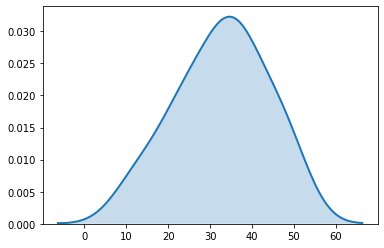

In [0]:
import seaborn as sns
from hyperopt.pyll.stochastic import sample
a ={'a': hp.normal('a', 31, 10)}
b = []
for _ in range(30):
  b.append(int(sample(a['a'])))
b

sns.kdeplot(b, linewidth = 2, shade = True)

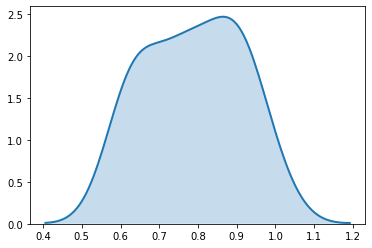

In [0]:
a ={'a': hp.uniform('a', 0.6, 1)}
b = []
for _ in range(30):
  b.append(sample(a['a']))
b

sns.kdeplot(b, linewidth = 2, shade = True)

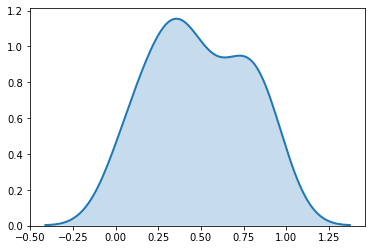

In [0]:
a ={'a': hp.uniform('a', 0.00001, 1)}
b = []
for _ in range(30):
  b.append(sample(a['a']))
b

sns.kdeplot(b, linewidth = 2, shade = True)

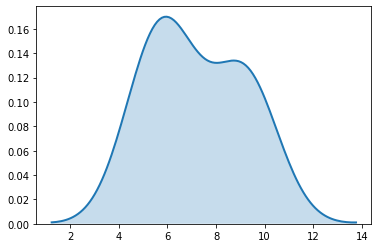

In [0]:
a ={'a': hp.quniform('a', 1, 10, 1)}
b = []
for _ in range(10):
  b.append(sample(a['a']))
b

sns.kdeplot(b, linewidth = 2, shade = True)

In [0]:
b

[9.0, 6.0, 7.0, 6.0, 9.0, 5.0, 10.0, 9.0, 6.0, 5.0]

###dart

In [0]:
fin_param(['dart'], num = 10, num_loop = 5)

Start......
Scores: 1.3385070267915042
Start......
Scores: 1.229748397518793
Start......
Scores: 1.171778281156752
Start......
Scores: 0.8068931858305345
Start......
Scores: 1.1884946468191238
100%|██████████| 5/5 [00:17<00:00,  3.65s/it, best loss: 0.8068931858305345]
{'bagging_fraction': 1.0, 'bagging_freq': 4.0, 'boosting': 0, 'cat_l2': 2.0, 'cat_smooth': 6.0, 'feature_fraction': 0.9, 'lambda_l1': 0.13721333680362857, 'lambda_l2': 0.5915941343479638, 'learning_rate': 0.4440806186711804, 'max_bin': 42.0, 'max_depth': 5.0, 'min_data_in_leaf': 70.0, 'min_gain_to_split': 0.31, 'min_sum_hessian_in_leaf': 0.3488510554260231, 'num_leaves': 34.85166813123721}


In [0]:
#its dart 100/50
# 100%|██████████| 50/50 [21:24<00:00, 23.80s/it, best loss: 0.5627758831784492]
# {'bagging_fraction': 1.0, 'bagging_freq': 5.0, 'cat_l2': 2.0, 'cat_smooth': 2.0, 'feature_fraction': 1.0, 'lambda_l1': 0.7409042536819661, 'lambda_l2': 0.2936292195158015, 'learning_rate': 0.4900184084648123, 'max_bin': 184.0, 'max_depth': 6.0, 'min_data_in_leaf': 20.0, 'min_gain_to_split': 1.3900000000000001, 'min_sum_hessian_in_leaf': 0.9550109807879941, 'num_leaves': 123.35903518091372}

### 1000/100

In [0]:
fin_param(['gbdt', 'dart', 'goss'], num = 1000, num_loop = 100)

#Если делать предик то dart именно на предикт лучше

In [0]:
param = {'boosting': 'dart',
         'n_estimators': 1000,
         'bagging_fraction': 1, 
         'bagging_freq': 5,
         'cat_l2': 2,
         'cat_smooth': 2,
         'feature_fraction': 1,
         'lambda_l1': 0.7409042536819661,
         'lambda_l2': 0.2936292195158015,
         'learning_rate': 0.4900184084648123,
         'max_bin': 184,
         'max_depth': 2,#6
         'min_data_in_leaf': 20, 
         'min_gain_to_split': 1.3900000000000001,
         'min_sum_hessian_in_leaf': 0.9550109807879941, 
         'num_leaves': 123}
model = lgb.LGBMRegressor(**param, random_state=13)
model.fit(X_train, np.log1p(y_train))
preds = model.predict(X_test)
cost(np.log1p(y_test), preds) #47

0.7608641885199362

In [0]:
param = {'bagging_fraction': 1,
         'n_estimators': 1000,
         'bagging_freq': 4,
         'boosting': 'gbdt',
         'cat_l2': 4,
         'cat_smooth': 8,
         'feature_fraction': 1, 
         'lambda_l1': 0.3649958771024604,
         'lambda_l2': 0.39118421353320576,
         'learning_rate': 0.305125828911035,
         'max_bin': 33,
         'max_depth': 2,#6
         'min_data_in_leaf': 100,
         'min_gain_to_split': 4.46,
         'min_sum_hessian_in_leaf': 0.0014733825324006822,
         'num_leaves': 27}

model = lgb.LGBMRegressor(**param, random_state=13)
model.fit(X_train, np.log1p(y_train))
preds = model.predict(X_test)
cost(np.log1p(y_test), preds)

0.6941198883222602

##cat

In [0]:
param_cat = {
    'iterations':100,
    'learning_rate':0.01,
    'depth':5,
    #l2_leaf_reg=5,
    'loss_function':'RMSE',
    'eval_metric':'RMSE',    
    'od_type':'Iter',
    'metric_period': 50,
    'od_wait':20,
    'verbose': 100,}   
    #'task_type':"GPU"}

In [0]:
idx_cat = np.where(train.drop(['meter_reading'], axis = 'columns').dtypes == 'category')[0]
idx_cat = np.insert(idx_cat, 0, 0) # add building id
model6 = catboost.CatBoostRegressor(**param_cat, random_state=13,cat_features=idx_cat)
cat_pred = cluster_id(train, X_test, 'building_id', model6, 3, skip = True)

In [0]:
cost(np.log1p(y_test), cat_pred)

1.0069551280832567

In [0]:
pred = cat_pred*0.75 + lgbm_pred*0.15 + pred_model1 *0.15
cost(np.log1p(y_test), pred)

0.9173532897078043

### Hyper

In [0]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [0]:
def rand_sample(f = 0.25):
  #вернет выборку рандомную, f - коеф. размера выборки
  np.random.seed(0)
  idx = np.argsort(train.timestamp.values, kind='stable')
  sample_idx = np.random.choice(idx, int(len(idx) * f), replace=False)  
  return sample_idx

sample_train = train.iloc[rand_sample(f = 0.25)] #4584686 rows × 45 columns

X = sample_train.drop('meter_reading', axis = 1)
y = sample_train.meter_reading

idx_cat = np.where(train.drop(['meter_reading'], axis = 'columns').dtypes == 'category')[0]
idx_cat = np.insert(idx_cat, 0, 0) # add building id

del train
gc.collect()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

train_pool = Pool(
    data=X_train, 
    label=np.log1p(y_train), 
    cat_features=idx_cat
)

validation_pool = Pool(
    data=X_test, 
    label=np.log1p(y_test), 
    cat_features=idx_cat
)

In [0]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.01,
    depth=5,
    #l2_leaf_reg=5,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed = 55,
    od_type='Iter',
    metric_period = 50,
    od_wait=20,
    verbose = 100,   
    task_type="GPU")

#model.fit(train_pool, eval_set=validation_pool,verbose= True)


In [0]:
cv_data = cv(train_pool,
             model.get_params())

0:	learn: 4660.1876836	test: 4659.8429835	best: 4659.8429835 (0)
99:	learn: 4366.8293143	test: 4365.7997957	best: 4365.7997957 (99)	total: 1m 33s	remaining: 0us


In [0]:
cv_data['test-RMSE-mean'].values[-1]

4365.799795691118

In [0]:
def fin_param_cat(num = 100, num_loop = 50):

  def hyperopt_objective(params):
      model = CatBoostRegressor(
          l2_leaf_reg=int(params['l2_leaf_reg']),
          learning_rate=params['learning_rate'],
          depth = params['depth'],
          random_strength = params['random_strength'],
          border_count = params['border_count'],
          grow_policy = params['grow_policy'],
          iterations=num,
          eval_metric='RMSE',
          random_seed=13,
          verbose=25,
          task_type = 'GPU',
          od_type = 'Iter',    
          od_wait = 20 
          )
      
      if params['grow_policy'] != 'SymmetricTree':
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])

      if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = int(params['max_leaves'])

      print(params, params['grow_policy'])

      cv_data = cv(
          train_pool,
          model.get_params()
      )
      score = cv_data['test-RMSE-mean'].values[-1]
      
      print(f'Scores: {score}')
      return {'loss': score, 'status':STATUS_OK}

  space = {
      'l2_leaf_reg': hp.qloguniform('l2_leaf_reg', 0, 5, 1),
      'learning_rate': hp.uniform('learning_rate', 1e-5, 5e-1),
      'depth': hp.quniform('max_depth', 3, 16, 1), 
      'random_strength': hp.quniform('random_strength', 1, 10, 1), 
      'border_count': hp.quniform('border_count', 1, 255, 1),
      'grow_policy': hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
      'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 100, 5),
      'max_leaves':hp.quniform('max_leaves', 1, 64, 1)
      }

  #bagging_temperature':, bootstrap type is Bayesian.

  trials = Trials()

  best = fmin(
      hyperopt_objective,
      space=space,
      algo=tpe.suggest,
      max_evals=num_loop,
      trials=trials
      )


  print(best)

In [0]:
%%time
#sample
fin_param_cat(num = 1000, num_loop = 100)

{'border_count': 233.0, 'depth': 14.0, 'grow_policy': 'Lossguide', 'l2_leaf_reg': 30.0, 'learning_rate': 0.13087812551661304, 'max_leaves': 40, 'min_data_in_leaf': 75, 'random_strength': 5.0}
Lossguide
0:	learn: 4.2882571	test: 4.2878714	best: 4.2878714 (0)

25:	learn: 0.9001967	test: 0.8959635	best: 0.8959635 (25)

50:	learn: 0.8143842	test: 0.8098745	best: 0.8098745 (50)

75:	learn: 0.7746332	test: 0.7701399	best: 0.7701399 (75)

100:	learn: 0.7451061	test: 0.7405193	best: 0.7405193 (100)

125:	learn: 0.7215315	test: 0.7168475	best: 0.7168475 (125)

150:	learn: 0.7023420	test: 0.6977985	best: 0.6977985 (150)

175:	learn: 0.6862682	test: 0.6819007	best: 0.6819007 (175)

200:	learn: 0.6735224	test: 0.6693046	best: 0.6693046 (200)

225:	learn: 0.6621575	test: 0.6579289	best: 0.6579289 (225)

250:	learn: 0.6518378	test: 0.6475433	best: 0.6475433 (250)

275:	learn: 0.6426789	test: 0.6385119	best: 0.6385119 (275)

300:	learn: 0.6339948	test: 0.6299381	best: 0.6299381 (300)

325:	learn: 0.6

In [0]:
%%time
#all

X = train.drop('meter_reading', axis = 1)
y = train.meter_reading

idx_cat = np.where(train.drop(['meter_reading'], axis = 'columns').dtypes == 'category')[0]
idx_cat = np.insert(idx_cat, 0, 0) # add building id

del train
gc.collect()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

train_pool = Pool(
    data=X_train, 
    label=np.log1p(y_train), 
    cat_features=idx_cat
)

validation_pool = Pool(
    data=X_test, 
    label=np.log1p(y_test), 
    cat_features=idx_cat
)

fin_param_cat(num = 2000, num_loop = 200)

In [0]:
%%time
#test split 1/2 train 33 predict 67

In [0]:
10/10
# 100%|██████████| 10/10 [04:21<00:00, 25.96s/it, best loss: 1251.0621906352042]
# {'border_count': 237.0, 'grow_policy': 1, 'l2_leaf_reg': 16.0, 'learning_rate': 0.3857377455824425, 'max_depth': 14.0, 'max_levels': 34.0, 'min_data_in_leaf': 75.0, 'random_strength': 6.0}

In [0]:
param = {'border_count': 237,
         'grow_policy': 'Lossguide',
         'l2_leaf_reg': 16,
         'learning_rate': 0.3857377455824425,
         'max_depth': 14, 
         'max_leaves': 34,
         'min_data_in_leaf': 75,         
         'iterations':10,
         'random_strength': 6,
         'eval_metric': 'RMSE',
          'random_seed':13,
          'verbose':25,
          'task_type': 'GPU',
          'od_type':'Iter',    
          'od_wait': 20 }


model = CatBoostRegressor(**param)
model.fit(train_pool, eval_set=validation_pool, verbose= True)
cost(np.log1p(y_test), model.predict(validation_pool))

0:	learn: 1.3660982	test: 1.3641469	best: 1.3641469 (0)	total: 41.6ms	remaining: 374ms
1:	learn: 1.1662561	test: 1.1635162	best: 1.1635162 (1)	total: 82.3ms	remaining: 329ms
2:	learn: 1.0622709	test: 1.0590210	best: 1.0590210 (2)	total: 122ms	remaining: 284ms
3:	learn: 1.0115332	test: 1.0086462	best: 1.0086462 (3)	total: 158ms	remaining: 237ms
4:	learn: 0.9834719	test: 0.9804637	best: 0.9804637 (4)	total: 196ms	remaining: 196ms
5:	learn: 0.9541355	test: 0.9512184	best: 0.9512184 (5)	total: 233ms	remaining: 156ms
6:	learn: 0.9343017	test: 0.9311612	best: 0.9311612 (6)	total: 270ms	remaining: 116ms
7:	learn: 0.9181914	test: 0.9150122	best: 0.9150122 (7)	total: 308ms	remaining: 77ms
8:	learn: 0.8864336	test: 0.8831310	best: 0.8831310 (8)	total: 345ms	remaining: 38.4ms
9:	learn: 0.8751879	test: 0.8720073	best: 0.8720073 (9)	total: 380ms	remaining: 0us
bestTest = 0.8720073294
bestIteration = 9


0.8720074318900298

In [0]:
#100/25
# 100%|██████████| 25/25 [41:08<00:00, 198.43s/it, best loss: 0.4331732718978858]
# {'border_count': 111.0, 'grow_policy': 1, 'l2_leaf_reg': 126.0, 'learning_rate': 0.30065425194784257, 'max_depth': 16.0, 'max_leaves': 54.0, 'min_data_in_leaf': 90.0, 'random_strength': 10.0}

In [0]:
param = {'border_count': 111, 
         'grow_policy': 'Depthwise',
         'l2_leaf_reg': 126,
         'learning_rate': 0.30065425194784257,
         'max_depth': 16,
         #'max_leaves': 54,
         'min_data_in_leaf': 90,
         'random_strength': 10,
         'iterations':10,
         'eval_metric': 'RMSE',
         'random_seed':13,
         'verbose':25,
         'task_type': 'GPU',
         'od_type':'Iter',    
         'od_wait': 20 }


model = CatBoostRegressor(**param)
model.fit(train_pool, eval_set=validation_pool, verbose= True)
cost(np.log1p(y_test), model.predict(validation_pool))

0:	learn: 1.2974143	test: 1.2964765	best: 1.2964765 (0)	total: 710ms	remaining: 6.39s
1:	learn: 0.9829202	test: 0.9826463	best: 0.9826463 (1)	total: 1.42s	remaining: 5.68s
2:	learn: 0.7766058	test: 0.7780297	best: 0.7780297 (2)	total: 2.13s	remaining: 4.96s
3:	learn: 0.6472978	test: 0.6509941	best: 0.6509941 (3)	total: 2.81s	remaining: 4.22s
4:	learn: 0.5674922	test: 0.5742277	best: 0.5742277 (4)	total: 3.5s	remaining: 3.5s
5:	learn: 0.5189099	test: 0.5288440	best: 0.5288440 (5)	total: 4.14s	remaining: 2.76s
6:	learn: 0.4890014	test: 0.5021229	best: 0.5021229 (6)	total: 4.78s	remaining: 2.05s
7:	learn: 0.4698688	test: 0.4857828	best: 0.4857828 (7)	total: 5.38s	remaining: 1.34s
8:	learn: 0.4572087	test: 0.4756696	best: 0.4756696 (8)	total: 5.93s	remaining: 659ms
9:	learn: 0.4478044	test: 0.4686911	best: 0.4686911 (9)	total: 6.45s	remaining: 0us
bestTest = 0.4686911279
bestIteration = 9


0.46869026346445714

#ends

In [0]:
model1 = Lasso(alpha = 1, random_state=13)
pred_model1 = cluster_id(train, test, 'building_id', model1, 3, skip = True)

params = {'bagging_fraction': 0.1,
          'boosting_type': 'gbdt',
          'feature_fraction': 0.7,
          'learning_rate': 0.1,
          'max_bin': 63,
          'max_depth': -1,
          'min_data_in_leaf': 20,
          'min_gain_to_split': 0.1,
          'n_estimators': 1000,
          'num_leaves': 120}

# params = {'bagging_fraction': 0.1, 
#           'boosting_type': 'dart',
#           'feature_fraction': 0.7,
#           'learning_rate': 0.1,
#           'max_bin': 63,
#           'max_depth': -1,
#           'min_data_in_leaf': 12,
#           'min_gain_to_split': 0.1,
#           'n_estimators': 1000,
#           'num_leaves': 120}


model4 = LGBMRegressor(params, random_state=13)
lgbm_pred = cluster_id(train, test, 'building_id', model4, 3, skip = True)

#knn
# param_knn = {'algorithm': 'ball_tree',
#              'n_neighbors': 15,
#              'p': 1, 
#              'weights': 'distance'}
# model5 = KNeighborsRegressor(param_knn)
# knn_pred = cluster_id(train, test, 'building_id', model5, 3, skip = True)

param_cat = {
    'iterations':1000,
    'learning_rate':0.01,
    'depth':5,
    #l2_leaf_reg=5,
    'loss_function':'RMSE',
    'eval_metric':'RMSE',
    'random_seed': 55,
    'od_type':'Iter',
    'metric_period': 50,
    'od_wait':20,
    'verbose': 100,   
    'task_type':"GPU"}

# param_cat = {
#     'iterations':2000,
#     'learning_rate':0.01,
#     'depth':2,
#     #l2_leaf_reg=5,
#     'loss_function':'RMSE',
#     'eval_metric':'RMSE',
#     'random_seed': 55,
#     'od_type':'Iter',
#     'metric_period': 50,
#     'od_wait':20,
#     'verbose': 100,   
#     'task_type':"GPU"}

idx_cat = np.where(train.drop(['meter_reading'], axis = 'columns').dtypes == 'category')[0]
idx_cat = np.insert(idx_cat, 0, 0) # add building id
model6 = catboost.CatBoostRegressor(param_cat, random_state=13,cat_features=idx_cat)
cat_pred = cluster_id(train, test, 'building_id', model6, 3, skip = True)

In [0]:
pred_df = pd.concat([knn_pred, pred_model1], axis =1).mean(axis = 1)
pred_df = pd.concat([lgbm_pred, knn_pred, pred_model1], axis =1).mean(axis = 1)
#pred = cat_pred * 0.6 + lgbm_pred * 0.2 + pred_df * .20
#pred = cat_pred * 0.6 + pred_df * .40

In [0]:
#pred = cat_pred * 0.3 + lgbm_pred * 0.3 + knn_pred * 0.2 + pred_model1 * 0.2
pred = cat_pred * 0.6 + lgbm_pred * 0.25 + knn_pred * 0.15
#pred = cat_pred * 0.45 + lgbm_pred * 0.25 + knn_pred * 0.15 + pred_model1 *0.15
#pred = cat_pred * 0.45 + lgbm_pred * 0.45 + knn_pred * 0.10
#pred = cat_pred * 0.7 + lgbm_pred * 0.15 + knn_pred * 0.15
#pred 

predictions = pd.DataFrame({
    "row_id": X.index,
    "meter_reading": np.clip(np.expm1(pred), 0, None)
})

best  1.1568